
## FINANCIAL ECONOMETRICS
MODULE 5 | LESSON 3

---

# **BAYESIAN ESTIMATION FOR GARCH MODEL**

|  |  |
|:---|:---|
|**Reading Time** | 60 minutes |
|**Prior Knowledge** | GARCH Model, Maximum Likelihood Estimation, Basic Statistics  |
|**Keywords** | Bayesian Statistics, Frequentist Statistics, Priors, Posteriors, Markov-Chain-Monte-Carlo, MCMC Convergence Diagnostics |


---

*In the last lesson, we mentioned the most commonly used estimation method for GARCH model is maximum likelihood estimation (MLE). In this lesson, we are going to introduce an alternative estimation method: Bayesian estimation. Bayesian estimation or Bayesian statistics is a branch in the field of statistics. It has a different approach from what we have learned so far to apply probability to data analysis. We will first introduce what Bayesian statistics is, how it works, and then we will discuss the differences between the Bayesian statistics and the statistical method we have been using. Then we will demonstrate how to use the Bayesian method to estimate the GARCH model. Bayesian statistics is a rich field in statistical analysis. In this lesson, we will only touch upon the surface of Bayesian statistics that should be enough for you to get through estimating a GARCH model. Apart from use in time series analysis, Bayesian statistics has gained a lot of interests in many areas that this is a subject worth diving into. We encourage interested students to seek more information about Bayesian statistics beyond this course.*

In [2]:
pip install arviz pymc pytensor


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import GARCH11
from pytensor import shared
import pytensor
pytensor.config.mode = 'NUMBA'

In [4]:
# Download the dataset
m5_data = pd.read_csv("M5. goog_eur_10.csv")

# Convert date variable to date format
m5_data["Date2"] = pd.to_datetime(m5_data["Date"], format="%m/%d/%Y")
goog = m5_data.loc[:, ["Date2", "GOOGLE"]].set_index("Date2")
goog["GOOGLE_R"] = np.log(goog.GOOGLE).diff().dropna()

## **1. Bayesian Statistics**
### **1.1 What is Bayesian Statistics?**
**Bayesian statistics** uses Bayes' theorem as the foundation to apply probabilities to data analysis. From the method we have been learning so far, we assume parameters like mean, variance, and standard deviations are unknown but fixed parameters. This method is called **frequentist statistics**. Maximum likelihood estimation belongs to frequentist statistics. On the other hand, in Bayesian statistics, mean, variance and standard deviations are random variables with probability distributions. This is the main difference between frequentist statistics and Bayesian statistics. To run Bayesian statistics, a researcher has to either use experience or other techniques to assume a parameter's probability distribution before running the analysis. We call these probability distributions **prior probability distributions** or **priors**. We then combine the information from data to derive **posterior probability distributions for parameters** or **posteriors**. The required readings in this lesson will provide definitions and applications of these concepts in more detail. It is good that now the parameters are not unknown fixed values but rather random variables. This change can make analysis more flexible. However, this method sometimes is criticized for subjective parameter probability distribution choice by the researcher before running the data analysis. There is a lot of debate about advantages and disadvantages of frequentist statistics vs. Bayesian statistics. For students who are interested in knowing more detail, there is a lot of material online.

### **1.2 Basics of Bayesian Updating, Prior Probability Distributions, Posterior Probability Distributions, and Likelihood Function**

Before continuing this lesson, please read the required readings for this lesson. The required readings will cover the concept of Bayesian updating, prior probability distributions (priors), posterior probability distributions (posteriors), and likelihood functions in detail. In the following sections of this lesson, we will use these concepts extensively so it is important that you are familiar with these concepts before proceeding to the next section.

### **1.3 Sampling from Posterior Probability Distribution**

We learned in the last section how to derive posterior probability distributions for parameters we are interested in analyzing. We know a posterior distribution is the multiplication of the likelihood function and the prior distribution. Oftentimes, a posterior distribution formula is too complicated to manipulate or is in high dimension. Hence, we have to conduct sampling to obtain a series of sample data points from the posterior distribution to investigate its marginal distribution density, mean, and other parameters. 

The most popular sampling method is the **Markov-Chain-Monte-Carlo (MCMC)** method. Monte Carlo is a random sampling method when the samples are independent. Markov-Chains address random samples that are autocorrelated to each other. Hence, MCMC method is a random sampling method for autocorrelated samples. There are several sampling algorithms under the MCMC method. The two most popular ones are the **Metropolis-Hastings algorithm** and the **Gibbs Sampling algorithm**. For those who are interested in the details of these algorithms, there are plenty of materials to explore online. For the following sections, the software we are using to conduct Bayesian estimation on GARCH models uses the Metropolis-Hastings algorithm. 

One final note about sampling before we move on to Bayesian estimation of GARCH models: The MCMC method can be sensitive to the initial values used to start sampling. Therefore, sometimes, we would use the result from maximum likelihood estimation as the starting values for Bayesian estimation. We will demonstrate this point when we show how to use Bayesian estimation in a later section.


## **2. Bayesian Estimation on GARCH Model**

In this section, we are going to go over the steps to use Bayesian method to fit a GARCH model. Specifically, we will focus on a GARCH model with Student's t innovations (errors). From the last lesson, we see that one common feature of financial asset returns is their heavy tail distribution. Hence, it is reasonable to use Student's t-distribution to model asset returns. 

Ardia and Hoogerheide (2010) demonstrated the steps using Bayesian estimation to fit a GARCH model with Student's t innovations. They wrote an R package (bayesGARCH) to automate the sampling process by using the Metropolis-Hastings algorithm. In the next section, we will use our Google stock return as an example to show the process. Before diving into the example, let's go over the theory for GARCH model with Student's t innovations first.

$$ r_{t} = \epsilon_{t} \sqrt{\frac{\nu-2}{\nu} \omega_{t} \sigma_{t}^{2}} $$ 

where 
> $t = 1, \cdots, T $ <br>
> $\epsilon_{t} \sim \text{iid normal} (0,1)$ <br>
> $ \omega_{t} \sim \text{iid inverse gamma} (\frac{\nu}{2}, \frac{\nu}{2})$ <br>
> $\sigma_{t}^{2} = \alpha_{0} + \alpha_{1} r_{t-1}^{2} + \beta \sigma_{t-1}^{2} $ where $\alpha_{0} > 0, \ \alpha_{1}, \beta \ge 0$ and $\nu \gt 2$. <br>

The restrictions above will ensure that the variance will be positive and finite. However, they do not ensure stationarity. We know from the last lesson that $\alpha_{1} + \beta < 1$ is needed to ensure stationary. We will use the result in our application later.

Another point we would like to explain is the inclusion of $\omega_{t}$. The reason we have $\omega_{t}$ as a prior multiplied with the variance of $r_{t}$ in the model is that the marginal distribution of $r_{t}$ will become a Student's t-distribution with degrees of freedom $\nu$.

The priors for $\alpha_{0}, \alpha_{1}, \beta$ are assumed to be truncated normal distributions with the domains greater than $0$ since these restrictions ensure positive and finite variance. The prior for $\nu$ is shifted exponential distribution. 

The joint posterior distribution will look like:

$$ p(\alpha_{0}, \alpha_{1}, \beta, \nu, \omega_{t} | r_{t}) = \frac{l(r_{t} | \alpha_{0}, \alpha_{1}, \beta, \nu, \omega_{t}) \ p(\alpha_{0}, \alpha_{1}, \beta, \nu, \omega_{t})}{p(r_{t})} $$

Then, MCMC will sample from the joint posterior distribution for each parameter. From the sampled data, we can generate the density for each parameter. As we mentioned in the last section, MCMC sampling can be sensitive to initial values. One method to avoid extreme values from initial values is to drop the first $n$ numbers of sampled observations. This is called a **burn-in** period. We can indicate to the package how many initial sampled observations we would like to drop from our sample series. We will elaborate more on this topic in the next section.


In this section, we will use Google stock return to fit a GARCH model by using the Bayesian estimation method. We will use Python package: PyMC to run this model. The PyMC package has inbuilt GARCH(1,1) distribution that will make the code easier to implement. We should bear in mind that the inbuilt GARCH distribution is with Normal innovations. However, from the Ardia and Hoogerheide (2006) we can learn that the priors for Bayesian GARCH(1,1) with Normal innovations remain the same. Hence, we provide this example for demonstration purposes.

We will use MCMC to generate two data sample series with 3000 samples in each series. In MCMC, a sample series is called a **chain**. Why do we need to sample two data series? We generate two chains because we need to use them to check if the sample series are close enough to the posterior that we want to analyze. This is called **convergence diagnostics** for MCMC sampling. There are several methods to conduct convergence diagnostics. We will use the Gelman-Rubin Diagnostic. The diagnostic provides a "Scale Reduction Factor" to indicate if several series converge. Usually, a value below 1.2 is okay. Since this diagnostic requires at least two chains, we will create two chains from MCMC. Figure 1 shows the MCMC sampling result for the joint posterior distribution for Google stock return GARCH model.

**Figure 1: First Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots**

In [5]:
# First Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots

# starting parameters = blank canvas model(0.000001, 0.000001, 0.000001)
alpha_mu = shared(np.array([0.000001, 0.000001], dtype=np.float64))
alpha_sigma = shared(np.array([[1000.0, 0.0], [0.0, 1000.0]], dtype=np.float64))

beta_mu = shared(np.array(0.000001, dtype=np.float64))
beta_sigma = shared(np.array(1000.0, dtype=np.float64))

# initial volatility
ivolatility = shared(np.array(0.000001, dtype=np.float64))
ivolatility_vol = shared(np.array(10.0, dtype=np.float64))

# construct MCMC model
mcmc0 = pm.Model()

with mcmc0:
    # create multivariate normal: p(α) ∝ φN2(α|µα,Σα) 1 {α ∈ R^2+}
    mvn = pm.MvNormal("mvNormal", mu=alpha_mu, cov=alpha_sigma, shape=2)

    # restrict the two coefficients to be greater than zero
    alp0 = pm.Deterministic("alpha0", pm.math.switch(mvn[0] > 0, mvn[0], -np.inf))
    alp1 = pm.Deterministic("alpha1", pm.math.switch(mvn[1] > 0, mvn[1], -np.inf))

    # create univariate truncated normal: p(β) ∝ φN1(β|µβ,Σβ) 1{β ∈ R+}
    nTruncated = pm.TruncatedNormal("beta", mu=beta_mu, sigma=beta_sigma, lower=0)
    volTruncated = pm.TruncatedNormal(
        "volatility", mu=ivolatility, sigma=ivolatility_vol, lower=0
    )

    # likelihood
    likelihood = GARCH11(
        "GARCH",
        omega=alp0,
        alpha_1=alp1,
        beta_1=nTruncated,
        initial_vol=volTruncated,
        observed=goog.GOOGLE_R.dropna() * 100,
    )

/usr/local/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [mvNormal]
>Slice: [beta]
>Slice: [volatility]


Output()

Sampling 2 chains for 0 tune and 3_000 draw iterations (0 + 6_000 draws total) took 112 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


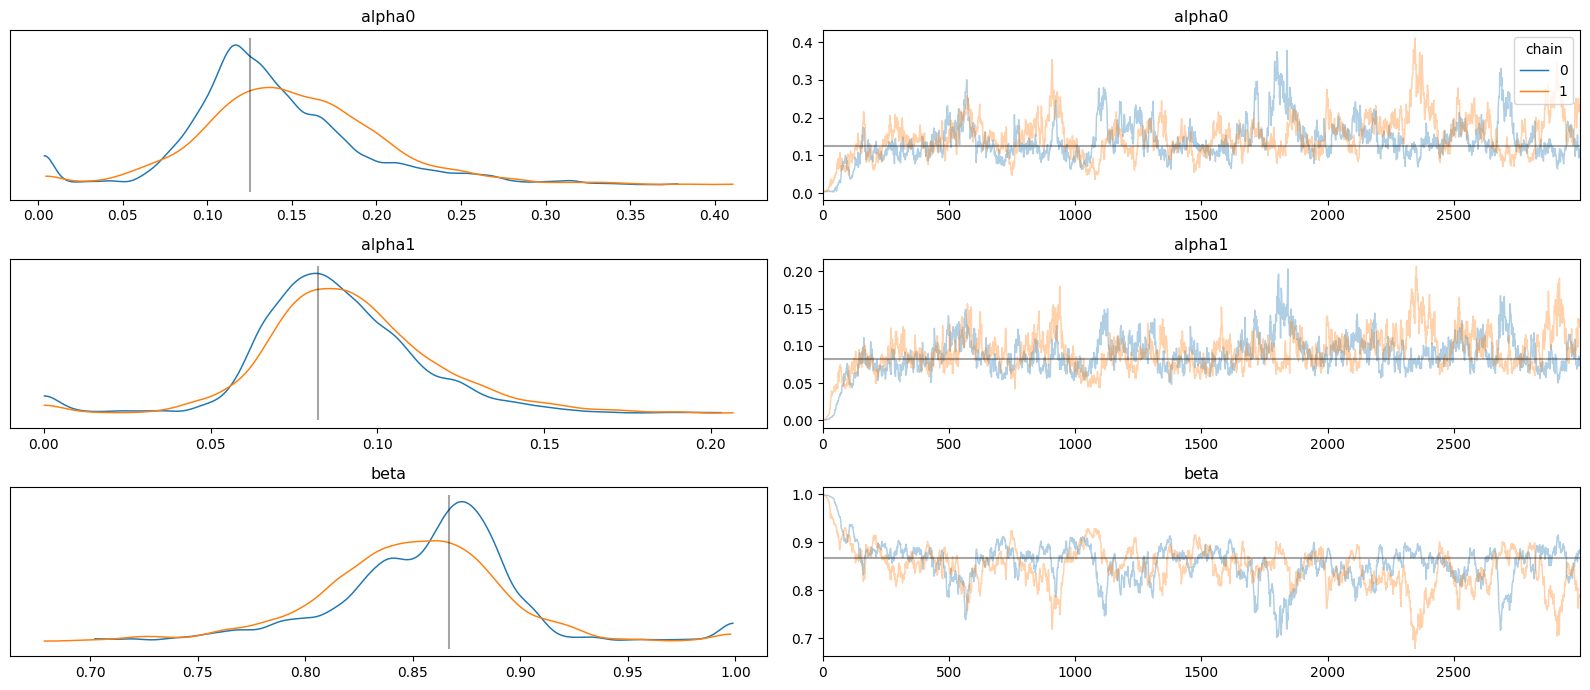

In [6]:
# Plot first round MCMC model posteriors
with mcmc0:
    step_mcmc0 = pm.Slice()
    trace_mcmc0 = pm.sample(
        3000,
        cores=2,
        step=step_mcmc0,
        tune=0,  # tune=0 => no burn-in
        return_inferencedata=True,
        random_seed=12345,
    )
    az.plot_trace(
        trace_mcmc0,
        var_names=["alpha0", "alpha1", "beta"],
        # plot vertical lines at GARCH(1,1) MLE param results
        lines=[
            ("alpha0", {}, [0.124993]),
            ("alpha1", {}, [0.082160]),
            ("beta", {}, [0.867127]),
        ],
        compact=False,
        legend=True,
        figsize=(16, 7),
    )
    plt.tight_layout()
    plt.show()

On the right of figure 1 are the plots called trace plots for parameters. Let's focus on the trace plot of *alpha0* for now to learn how to read the plot. There are two series on the trace plot. One is blue and the other is orange. They represent the two chains sampled from MCMC. Let's focus on the blue one first. The trace plot lays out the way that the first sampled data is on the leftmost side of the plot, and the second sampled data follows it to the right and so on and so forth. We can see that the first 300 samples start with very volatile movement. As more and more sampled data is collected, the series starts to converge to a value of around $0.12$. However, there is some volatility between the 1700th sample and 3000th sample. The orange chain in general demonstrates a pattern similar to the blue chain. Let's run the summary test to see how well the MCMC sample converges.

**Figure 2: First Round MCMC Convergence Test Result and Parameter Estimations**

In [7]:
# First Round MCMC Convergence Test Result and Parameter Estimations
az.summary(trace_mcmc0, round_to=7).loc[["alpha0", "alpha1", "beta"], :]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,0.145094,0.053294,0.059351,0.262754,0.007721,0.004627,47.599936,51.832998,1.068832
alpha1,0.089880,0.025170,0.048496,0.141094,0.003876,0.002370,47.796746,48.588985,1.066640
beta,0.852806,0.042358,0.757265,0.916286,0.006640,0.004178,44.814853,48.402712,1.074747


Last column in Figure 2 for *r_hat* represents the Gelman-Rubin statistic. It tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. If *r_hat* < 1.2 for all model parameters, we can have some confidence that convergence has been reached.

Let's look at the estimations for the parameters. Figure 2 shows the estimated parameters from the first round MCMC sampling result. Let's focus on the means of the coefficients. We see *alpha0*, *alpha1* and *beta* all look reasonable within our restrictions for stationary and positive and finite variance. But so far the model represents so called 'blank canvas' model i.e. we have not accounted for any meaningful starting values. In this initial model the starting values are all near zero for all *alpha0*, *alpha1* and *beta* priors. 

We discussed in the previous section that the MCMC can be sensitive to starting value. If starting value is way off, it can impact the final result of MCMC. In this case, we can assign starting values to parameters before the MCMC starts sampling. In that way, we restrain MCMC from going wild when sampling. So where can we find initial values for parameters? In the previous lesson, we estimated the parameters using maximum likelihood. We can use these estimates as starting values for MCMC. Otherwise, this step is a trial-and-error process. You might need to run MCMC a number of times for MCMC to converge to a solution and find reasonable coefficient estimates. 

For the next round of MCMC, we adjust starting values for parameters in the code and rerun MCMC. The following figures show the final results of the second run MCMC sampling.

**Figure 3: Second Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots**

In [8]:
# Second Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots

# starting parameters = MLE(0.124993, 0.082160, 0.867127)
alpha_mu = shared(np.array([0.124993, 0.082160], dtype=np.float64))
alpha_sigma = shared(np.array([[1000.0, 0.0], [0.0, 1000.0]], dtype=np.float64))

beta_mu = shared(np.array(0.867127, dtype=np.float64))
beta_sigma = shared(np.array(1000.0, dtype=np.float64))

# initial volatility
ivolatility = shared(
    np.array(1.63865, dtype=np.float64)
)  # np.std(goog["GOOGLE_R"].dropna()*100)
ivolatility_vol = shared(np.array(10.0, dtype=np.float64))

# construct MCMC model
mcmc = pm.Model()

with mcmc:
    # create a multivariate normal: p(α) ∝ φN2(α|µα,Σα) 1 {α ∈ R^2+}
    mvn = pm.MvNormal("mvNormal", mu=alpha_mu, cov=alpha_sigma, shape=2)

    # restrict the two coefficients to be greater than zero
    alp0 = pm.Deterministic("alpha0", pm.math.switch(mvn[0] > 0, mvn[0], -np.inf))
    alp1 = pm.Deterministic("alpha1", pm.math.switch(mvn[1] > 0, mvn[1], -np.inf))

    # create univariate truncated normal: p(β) ∝ φN1(β|µβ,Σβ) 1{β ∈ R+}
    nTruncated = pm.TruncatedNormal("beta", mu=beta_mu, sigma=beta_sigma, lower=0)
    volTruncated = pm.TruncatedNormal(
        "volatility", mu=ivolatility, sigma=ivolatility_vol, lower=0
    )

    # likelihood
    likelihood = GARCH11(
        "garch",
        omega=alp0,
        alpha_1=alp1,
        beta_1=nTruncated,
        initial_vol=volTruncated,
        observed=goog.GOOGLE_R.dropna() * 100,
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [mvNormal]
>Slice: [beta]
>Slice: [volatility]


Output()

Sampling 2 chains for 0 tune and 3_000 draw iterations (0 + 6_000 draws total) took 101 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


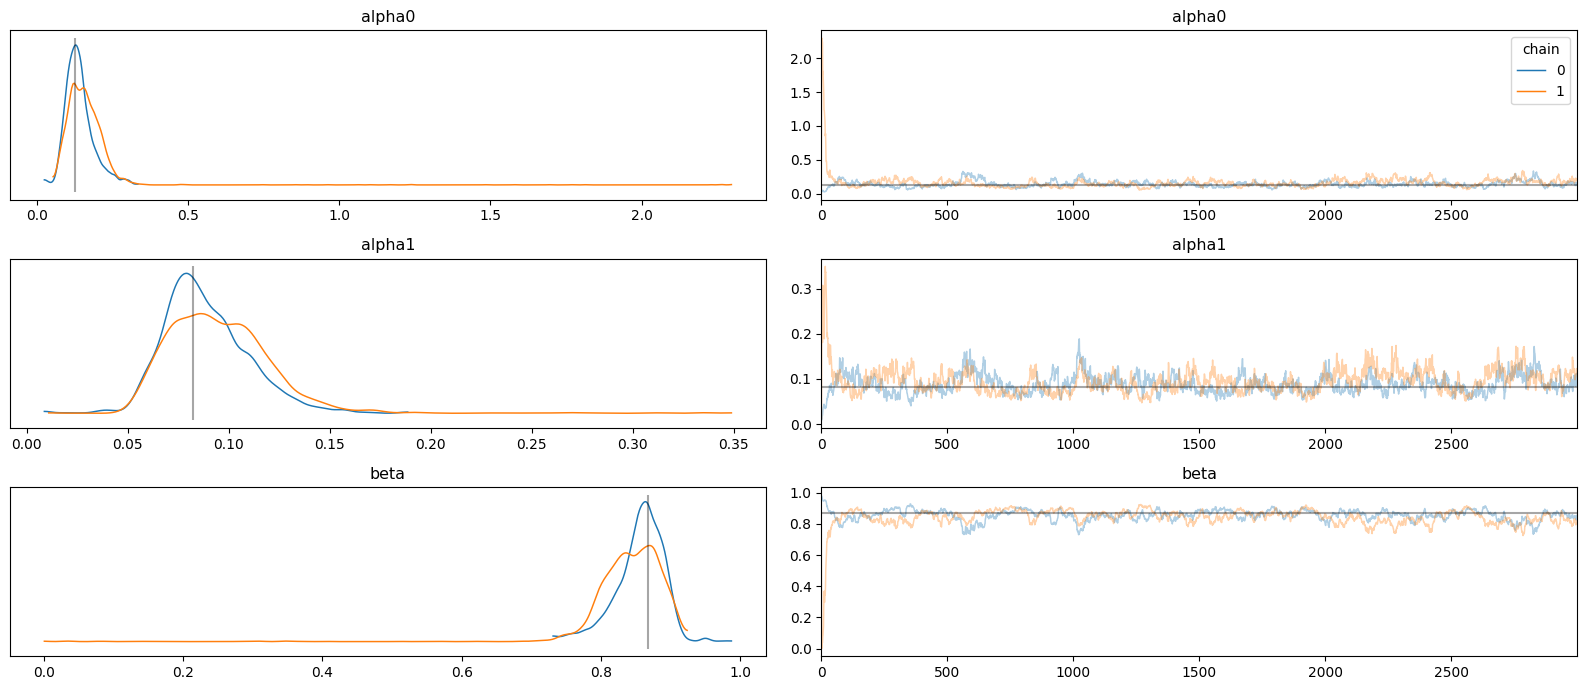

In [9]:
# Plot Second round MCMC model posteriors
with mcmc:
    step_mmc = pm.Slice()
    trace_mmc = pm.sample(
        3000,
        cores=2,
        step=step_mmc,
        tune=0,  # no burn-in
        return_inferencedata=True,
        random_seed=12345,
    )
    az.plot_trace(
        trace_mmc,
        var_names=["alpha0", "alpha1", "beta"],
        lines=[
            ("alpha0", {}, [0.124993]),
            ("alpha1", {}, [0.082160]),
            ("beta", {}, [0.867127]),
        ],
        compact=False,
        legend=True,
        figsize=(16, 7),
    )
    plt.tight_layout()
    plt.show()

In figure 3, we can see that after adding starting values to the code, the trace plot for all priors converges better in this round of MCMC. Let's check the Gelman-Rubin convergence test and other parameter estimations.

**Figure 4: Second Round MCMC Convergence Test Result**


In [10]:
# Second Round MCMC Sampling Result: Parameter estimation
az.summary(trace_mmc, round_to=7).loc[["alpha0", "alpha1", "beta"], :]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,0.151440,0.091908,0.067844,0.240691,0.007156,0.043919,82.938764,221.227579,1.029334
alpha1,0.092149,0.024706,0.054129,0.132585,0.002455,0.002861,92.183544,318.266329,1.024602
beta,0.848298,0.051242,0.782080,0.913977,0.004892,0.015678,75.874103,231.988360,1.030617


We can see from figure 4 that all the parameters have converged pretty well after adding starting values to the code and *r_hat* improved.

However, we can still see from figure 3 that the first 250 data points seem to be very volatile. We can treat them as the burn-in period and drop those sampled data points. At this point, we will also combine chains. Let's check out the MCMC result after these steps.

**Figure 5: Second Round MCMC Sampling Result: Parameter Trace Plots and Density Plots After Adjustment**

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [mvNormal]
>Slice: [beta]
>Slice: [volatility]


Output()

Sampling 2 chains for 250 tune and 3_000 draw iterations (500 + 6_000 draws total) took 87 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


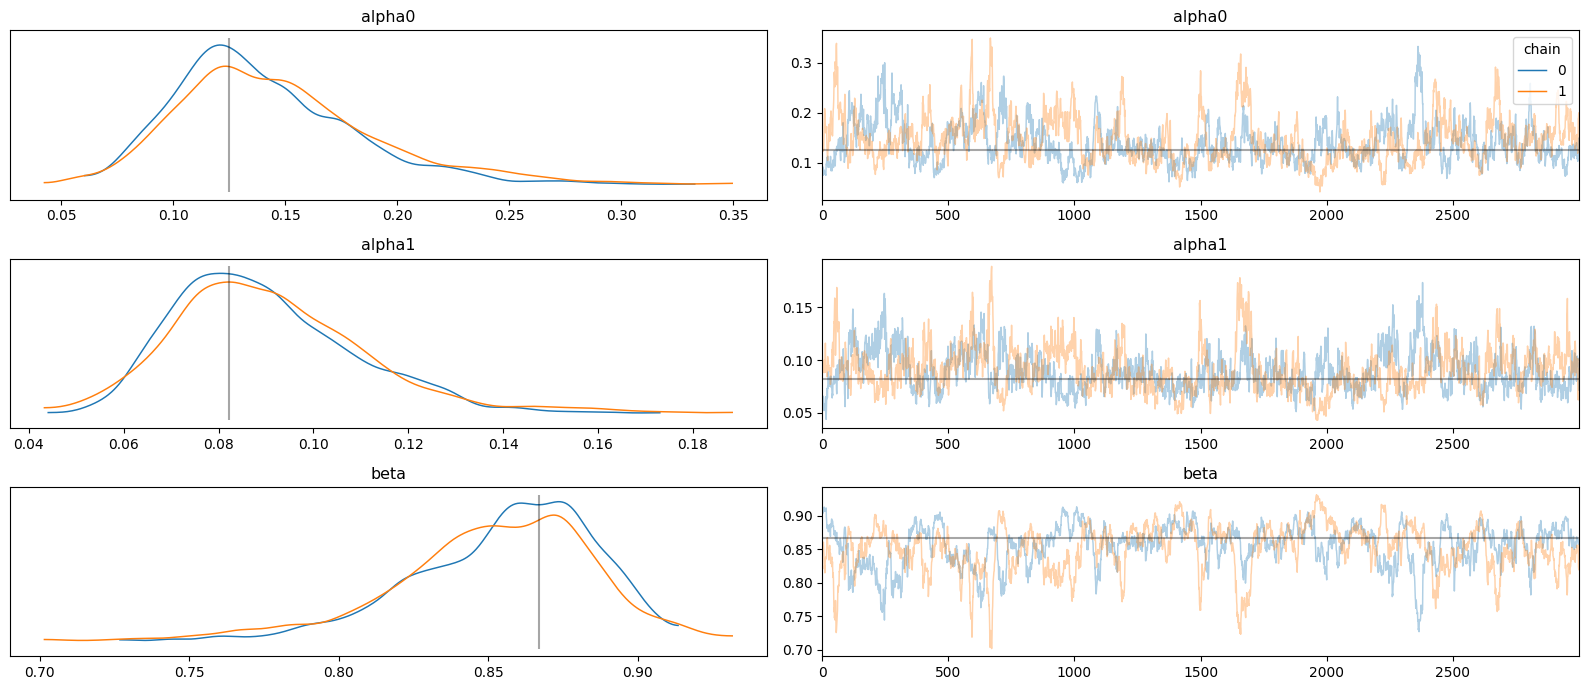

In [11]:
# Second Round MCMC Sampling Result: Parameter Trace Plots and Density Plots After Adjustment
with mcmc:
    step_mmc_a = pm.Slice()
    trace_mmc_a = pm.sample(
        3000,
        cores=2,
        step=step_mmc_a,
        tune=250,  # burn-in = 250 steps
        return_inferencedata=True,
        random_seed=12345,
    )
    az.plot_trace(
        trace_mmc_a,
        var_names=["alpha0", "alpha1", "beta"],
        lines=[
            ("alpha0", {}, [0.124993]),
            ("alpha1", {}, [0.082160]),
            ("beta", {}, [0.867127]),
        ],
        compact=False,
        legend=True,
        figsize=(16, 7),
    )
    plt.tight_layout()
    plt.show()

From figure 5, we can see the trace plots for 3 parameters all oscillate within a narrower range compared to the trace plots in figure 1. On the left, we can see that the marginal densities of *alpha0* and *alpha1* seem to skew to the right while the marginal density for beta skew to the left. Let's check the final parameter estimates.

**Figure 6: First Round MCMC Sampling Result: Parameter Estimation with Adjustment**

In [12]:
# First Round MCMC Sampling Result: Parameter Estimation with Adjustment
az.summary(trace_mmc_a, round_to=7).loc[["alpha0", "alpha1", "beta"], :]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,0.143620,0.043415,0.074571,0.231585,0.004067,0.002347,108.231247,235.146465,1.008775
alpha1,0.090170,0.019715,0.057861,0.128158,0.001783,0.001058,119.996201,301.232062,1.003836
beta,0.852987,0.032861,0.786890,0.907703,0.003265,0.001904,97.762053,211.792705,1.007301


In figure 6, we can see that all estimated coefficients are well behaved and confined in the restrictions to meet stationarity and positive and finite variance requirements. In figure 7 below, we can compare the estimated coefficients from MLE and Bayesian estimations. We can see the estimated coefficients are similar. We achieved this comparable result partly because we used MLE estimates as our starting values for MCMC sampling. By carefully selecting starting values for MCMC, we can control the behavior of the estimated coefficients.

**Figure 7: Google Stock Return, GARCH Model Estimated Parameters Comparison Between MLE and Bayesian**

|              | MLE(norm) | MLE(st) | Bayesian |
| :---:        |      ---: |    ---: |     ---: |
| omega/alpha0 |   0.1250  |  0.0616 |  0.1436  |
| alpha1       |   0.0822  |  0.1039 |  0.0901  |
| beta         |   0.8671  |  0.8865 |  0.8530  |


## **4. Conclusion**

In this lesson, we first introduced Bayesian statistics. We discussed Bayesian statistics and the main difference between the frequentist and Bayesian methods. Then, we looked at Bayesian updating, prior distributions, likelihood functions, and posterior distributions. Next, we described how MCMC can sample data from posterior distribution for analysis. Finally, we use the Google stock return to run a GARCH model and described the steps required to run Bayesian estimation for this GARCH model. Bayesian statistics is a powerful tool to learn apart from the frequentist method we are already very familiar with. Bayesian statistics will also play an important role in machine learning, which you will learn in the following course.

## **References**

- Ardia, David, "Bayesian Estimation of the GARCH(1,1) Model with Normal Innovations", Munich Personal RePEc Archive, September 2006

- Ardia, David, and Lennart F. Hoogerheide. "Bayesian Estimation of the GARCH(1,1) Model with Student-t Innovations." The R Journal, vol. 2, 2010, pp. 41–47.


---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.